In [3]:
import seaborn as sns

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-pastel')
plt.style.use('bmh')

# Import data

In [35]:
daily_data = pd.read_csv('03-tweets_daily.csv',
                     lineterminator='\n', 
                     parse_dates=['timestamp']
                     index_col='timestamp')

In [67]:
daily_data['next_close_label'].value_counts()

1    274
0    272
Name: next_close_label, dtype: int64

Text(0.5, 1.0, 'Number  of labels')

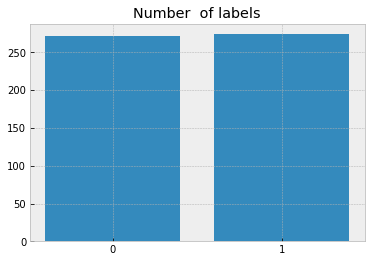

In [ ]:
plt.bar(daily_data['next_close_label'].value_counts().index, daily_data['next_close_label'].value_counts())
plt.xticks([0,1])
plt.title("Number  of labels")

remove unwanted columns

In [36]:
daily_data.drop(['fear_greed_class', 
                 'DoW_Monday', 'DoW_Saturday', 'DoW_Sunday','DoW_Thursday', 'DoW_Tuesday', 'DoW_Wednesday'
       ], axis=1, inplace=True)

In [37]:
daily_data.columns

Index(['polarity_textblob', 'count_of_tweets', 'percent_vader_pos',
       'percent_vader_neg', 'percent_pattern_pos', 'Volume', 'Open',
       'next_open_label', 'Close', 'next_close_label', 'trends_bitcoin',
       'fear_greed_value', 'wikiviews_bitcoin', 'wikiviews_cryptocurrency',
       'High', 'Low', 'next_close', 'next_return', 'hlco_ratio',
       'upper_shadow', 'lower_shadow', 'is_weekend'],
      dtype='object')

Text(0.5, 0, 'Date')

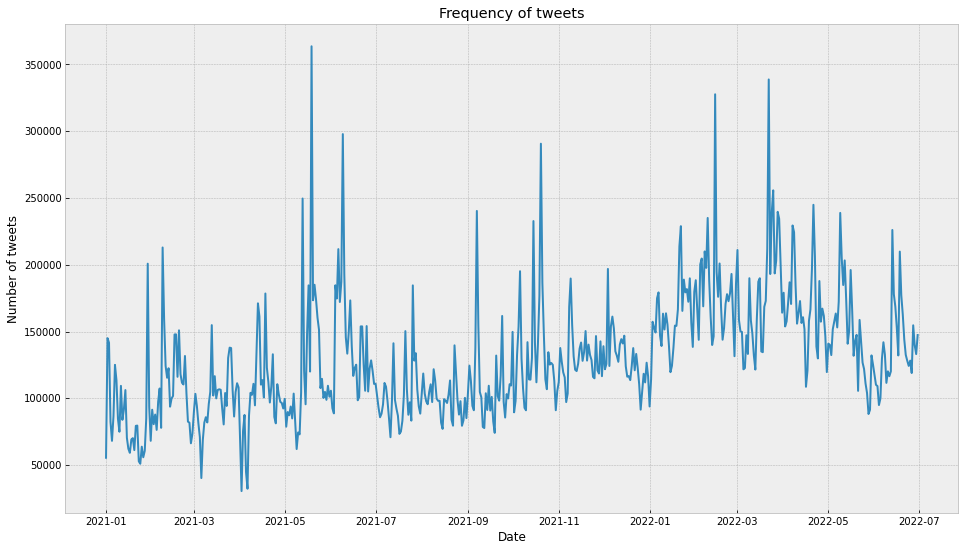

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Frequency of tweets')
plt.plot(daily_data['count_of_tweets'])
plt.ylabel('Number of tweets')
plt.xlabel('Date')

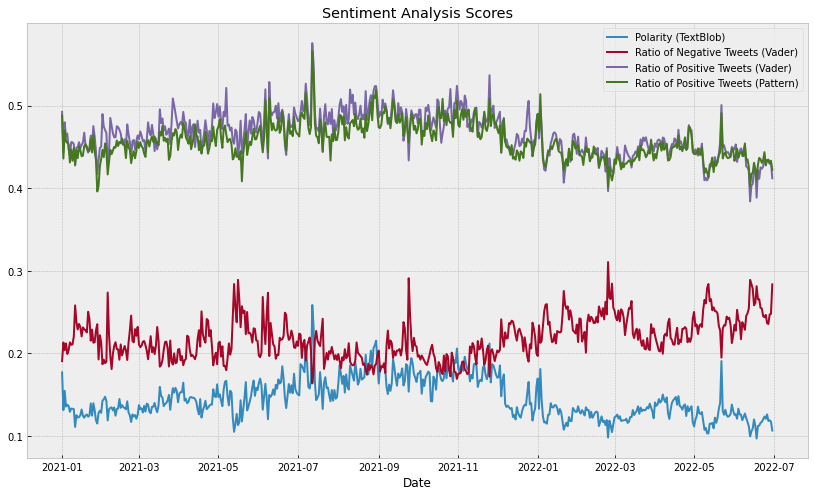

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Sentiment Analysis Scores')
plt.plot(daily_data['polarity_textblob'], label='Polarity (TextBlob)')
plt.plot(daily_data['percent_vader_neg'], label='Ratio of Negative Tweets (Vader)')
plt.plot(daily_data['percent_vader_pos'], label='Ratio of Positive Tweets (Vader)')
plt.plot(daily_data['percent_pattern_pos'], label='Ratio of Positive Tweets (Pattern)')
plt.xlabel('Date')
plt.legend()

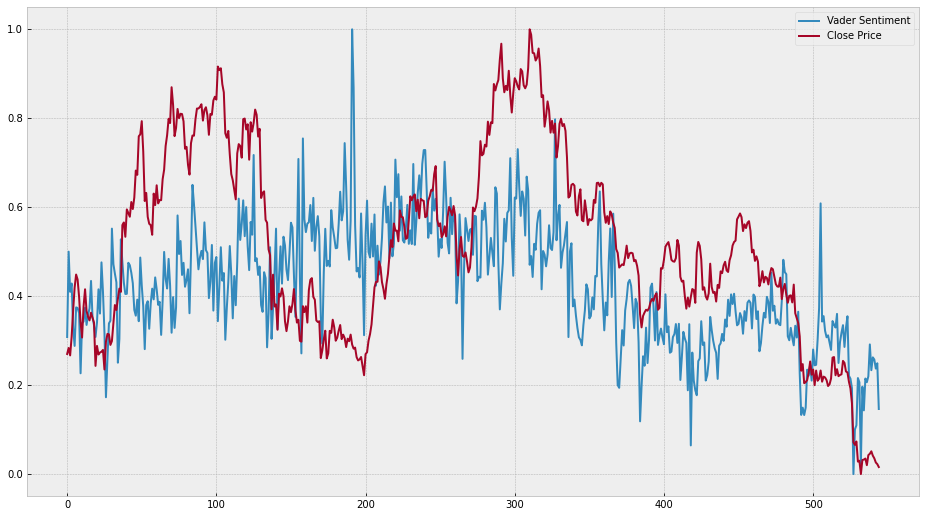

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(X['percent_vader_pos'], label = 'Vader Sentiment')
plt.plot(X['Close'], label = 'Close Price')

plt.legend()

# Add percent change features

In [40]:
pct_change_data = daily_data.drop(['Open','next_open_label', 'next_close_label', 'next_return', 'next_close',
                'High', 'Low',
                 'hlco_ratio','upper_shadow', 'lower_shadow', 'is_weekend',
                ],
                axis=1).pct_change()

In [41]:
for col in pct_change_data.columns:
  pct_change_data.rename(columns={col: f'{col} (change)'}, inplace=True)

In [42]:
daily_data = pd.concat([daily_data, pct_change_data], axis=1)

In [43]:
daily_data.columns

Index(['polarity_textblob', 'count_of_tweets', 'percent_vader_pos',
       'percent_vader_neg', 'percent_pattern_pos', 'Volume', 'Open',
       'next_open_label', 'Close', 'next_close_label', 'trends_bitcoin',
       'fear_greed_value', 'wikiviews_bitcoin', 'wikiviews_cryptocurrency',
       'High', 'Low', 'next_close', 'next_return', 'hlco_ratio',
       'upper_shadow', 'lower_shadow', 'is_weekend',
       'polarity_textblob (change)', 'count_of_tweets (change)',
       'percent_vader_pos (change)', 'percent_vader_neg (change)',
       'percent_pattern_pos (change)', 'Volume (change)', 'Close (change)',
       'trends_bitcoin (change)', 'fear_greed_value (change)',
       'wikiviews_bitcoin (change)', 'wikiviews_cryptocurrency (change)'],
      dtype='object')

In [44]:
daily_data.shape

(546, 33)

# Plots

Clustered correlation heatmap

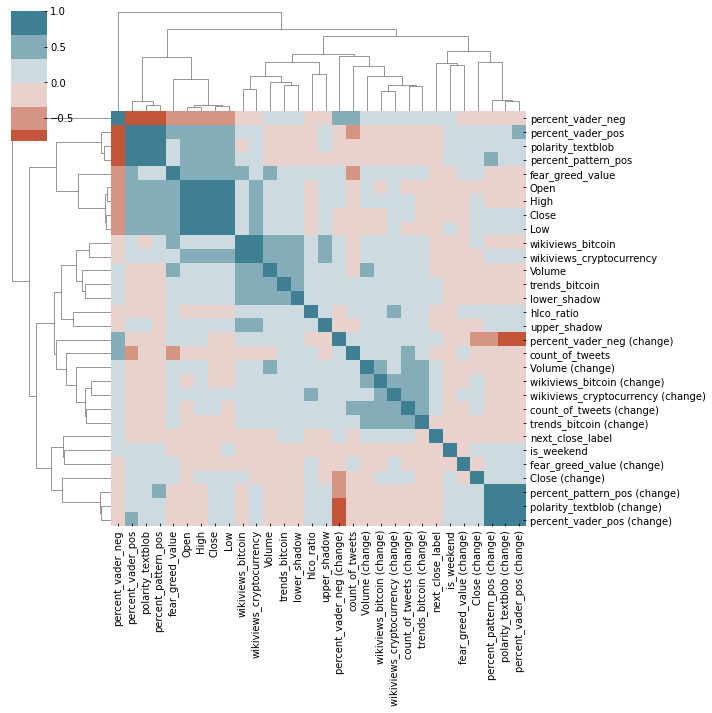

In [24]:
sns.clustermap(daily_data.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((10, 10))

# Modeling

### validation set


Train, validation, test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 random_state=0,shuffle=True)

# Normalizing data

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
scl = StandardScaler()

In [3]:
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

X = scl.fit_transform(daily_data)

In [52]:
X_train = daily_data.iloc[:train_index]
X_val = daily_data.iloc[train_index:val_index]
X_test = daily_data.iloc[val_index:]

# Auto ML

## Tpot

In [ ]:
%%capture
!pip install tpot

In [ ]:
from tpot import TPOTClassifier

In [ ]:
tpot = TPOTClassifier(
    generations=5, #number of iterations to run the training
    population_size=20, #number of individuals to train
    cv=3, #number of folds in StratifiedKFold
    verbosity=2, random_state=0)
tpot.fit(X_train, y_train)

print(tpot.score(X_test, y_test))

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5461206896551724

Generation 2 - Current best internal CV score: 0.5461206896551724

Generation 3 - Current best internal CV score: 0.5461206896551724

Generation 4 - Current best internal CV score: 0.5529533844189016

Generation 5 - Current best internal CV score: 0.5529533844189016

Best pipeline: RandomForestClassifier(Binarizer(CombineDFs(input_matrix, input_matrix), threshold=0.45), bootstrap=True, criterion=gini, max_features=0.35000000000000003, min_samples_leaf=16, min_samples_split=11, n_estimators=100)
0.4909090909090909


# Tuning

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

## Sklearn

In [55]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## Optuna

### Import

In [56]:
%%capture
!pip install optuna
!pip install shap

In [57]:
import optuna
from functools import partial
from sklearn.metrics import classification_report, log_loss, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import shap

### Nearest neighbor

In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value  params_leaf_size params_metric  params_n_neighbors  params_p  \
1999  0.581818                50     minkowski                   4         2   
687   0.581818                28     minkowski                   4         2   
1558  0.581818                14     minkowski                   4         2   

     params_weights     state  
1999        uniform  COMPLETE  
687         uniform  COMPLETE  
1558        uniform  COMPLETE

Validation accuracy: 0.5740740740740741
Test accuracy: 0.5818181818181818
Classification report: (test) 

              precision    recall  f1-score   support

           0       0.69      0.38      0.49        29
           1       0.54      0.81      0.65        26

    accuracy                           0.58        55
   macro avg       0.61      0.59      0.57        55
weighted avg       0.62      0.58      0.56        55

Log Loss: (test) 14.443749997030716

Confusion Matrix: (test) 

[[11 18]
 [ 5 21]]


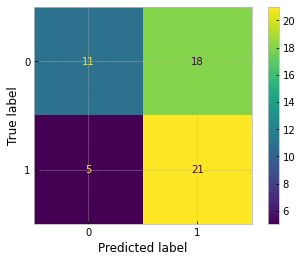

In [ ]:
params = study.best_trial.params
clf = KNeighborsClassifier(**params)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))
y_predict = clf.predict(X_test)
print('Classification report: (test) \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: (test) {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: (test) \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False) disp.im_.set_clim(0, 25)

withlag

In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value  params_leaf_size params_metric  params_n_neighbors  params_p  \
1999  0.565556                23     chebyshev                   5         1   
649   0.565556                46     chebyshev                   5         2   
630   0.565556                37     chebyshev                   5         2   

     params_weights     state  
1999       distance  COMPLETE  
649         uniform  COMPLETE  
630         uniform  COMPLETE

### Linear SVM

In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value   params_C     state
46  0.527273  18.450377  COMPLETE
31  0.527273  17.001475  COMPLETE
66  0.527273  14.696573  COMPLETE

Validation accuracy: 0.5185185185185185
Test accuracy: 0.5272727272727272
Classification report: 

              precision    recall  f1-score   support

           0       1.00      0.10      0.19        29
           1       0.50      1.00      0.67        26

    accuracy                           0.53        55
   macro avg       0.75      0.55      0.43        55
weighted avg       0.76      0.53      0.41        55

Log Loss: 16.327799560015695

Confusion Matrix: 

[[ 3 26]
 [ 0 26]]


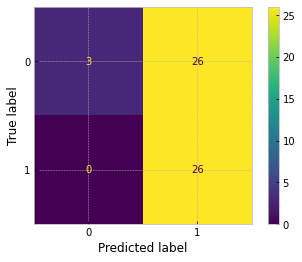

In [ ]:
params = study.best_trial.params
clf = SVC(**params, kernel="linear", probability=True, random_state=42)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False) disp.im_.set_clim(0, 25)

In [ ]:
%%capture
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

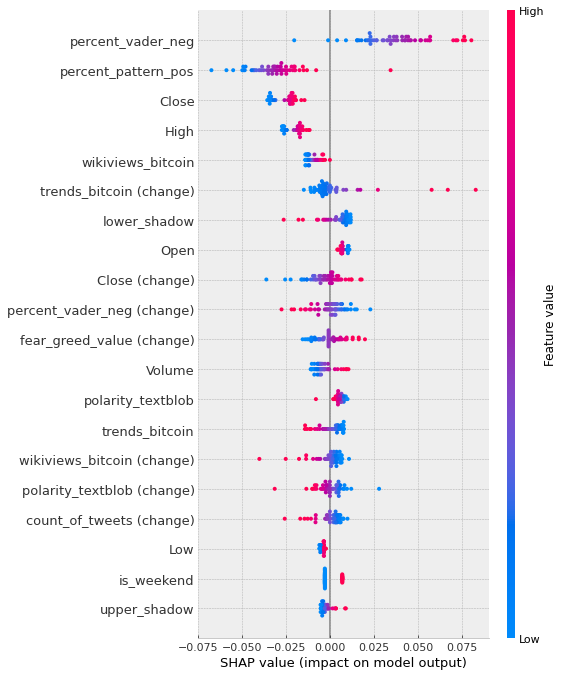

In [ ]:
shap.summary_plot(shap_values[1], X_test)

Validation accuracy: 0.6111111111111112
Test accuracy: 0.5454545454545454
Classification report: 

              precision    recall  f1-score   support

           0       0.61      0.38      0.47        29
           1       0.51      0.73      0.60        26

    accuracy                           0.55        55
   macro avg       0.56      0.56      0.54        55
weighted avg       0.56      0.55      0.53        55

Log Loss: 15.699705502300198

Confusion Matrix: 

[[11 18]
 [ 7 19]]


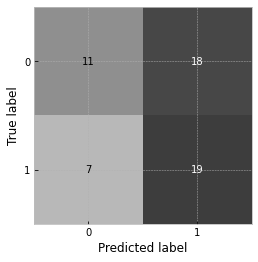

In [27]:
params = study.best_trial.params
clf = DecisionTreeClassifier(**params, random_state=42)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))
y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False)
disp.im_.set_clim(0, 25)

### Random Forest

In [28]:
def objective(trial):
    # classifier_obj =  RandomForestClassifier(
    #         n_estimators=trial.suggest_int("n_estimators", 10, 200),
    #         max_depth=trial.suggest_int("max_depth", 2, 64, log=True),
    #         max_features = trial.suggest_uniform("max_features", 0.01, 1.0), 
    #         criterion = trial.suggest_categorical("criterion", ["gini", "entropy"]),
    #         random_state=42
    # )
    classifier_obj =  RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 10, 1000),
            max_depth=trial.suggest_int("max_depth", 2, 64, log=True),
            min_samples_split= trial.suggest_int('min_samples_split', 2, 150),
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 60),
            max_features = trial.suggest_uniform("max_features", 0.01, 1.0), 
            criterion = trial.suggest_categorical("criterion", ["gini", "entropy"]),
            random_state=42
    )    
    # score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    # accuracy = score.mean()
    # return accuracy
    clf=classifier_obj.fit(X_train, y_train)
    pred_test_labels=clf.predict(X_test)
    pred_val_labels=clf.predict(X_val)
    val_acc = accuracy_score(y_val, pred_val_labels)
    test_acc = accuracy_score(y_test, pred_test_labels)
    return min(val_acc,test_acc)

optimization_function = partial(objective)
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(optimization_function, n_trials=1000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-05 13:56:58,322] A new study created in memory with name: no-name-602a8b8e-7c12-4ac6-8fd1-2bc021ace03f
[I 2022-08-05 13:57:02,782] Trial 0 finished with value: 0.4727272727272727 and parameters: {'n_estimators': 757, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 18, 'max_features': 0.26334086998534145, 'criterion': 'entropy'}. Best is trial 0 with value: 0.4727272727272727.
[I 2022-08-05 13:57:06,873] Trial 1 finished with value: 0.4909090909090909 and parameters: {'n_estimators': 670, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 30, 'max_features': 0.8109247956419039, 'criterion': 'gini'}. Best is trial 1 with value: 0.4909090909090909.
[I 2022-08-05 13:57:07,643] Trial 2 finished with value: 0.4909090909090909 and parameters: {'n_estimators': 131, 'max_depth': 11, 'min_samples_split': 40, 'min_samples_leaf': 38, 'max_features': 0.9801709282131209, 'criterion': 'gini'}. Best is trial 1 with value: 0.4909090909090909.
[I 2022-08-05 13:57:08,0

Number of finished trials:  1000
Best trial:
  Value: 0.5636363636363636
  Params: 
    n_estimators: 116
    max_depth: 60
    min_samples_split: 118
    min_samples_leaf: 57
    max_features: 0.8588413206843837
    criterion: gini


In [29]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value params_criterion  params_max_depth  params_max_features  \
744  0.563636             gini                 9             0.830110   
674  0.563636             gini                60             0.858841   
878  0.563636          entropy                 9             0.837721   

     params_min_samples_leaf  params_min_samples_split  params_n_estimators  \
744                       57                       120                  114   
674                       57                       118                  116   
878                       55                       122                  124   

        state  
744  COMPLETE  
674  COMPLETE  
878  COMPLETE

Validation accuracy: 0.5925925925925926
Test accuracy: 0.5636363636363636
Classification report: 

              precision    recall  f1-score   support

           0       0.73      0.28      0.40        29
           1       0.52      0.88      0.66        26

    accuracy                           0.56        55
   macro avg       0.62      0.58      0.53        55
weighted avg       0.63      0.56      0.52        55

Log Loss: 15.071771364070742

Confusion Matrix: 

[[ 8 21]
 [ 3 23]]


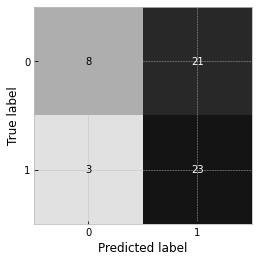

In [30]:
params = study.best_trial.params
clf = RandomForestClassifier(**params, random_state=42)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False)
disp.im_.set_clim(0, 25)

In [ ]:
%%capture
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

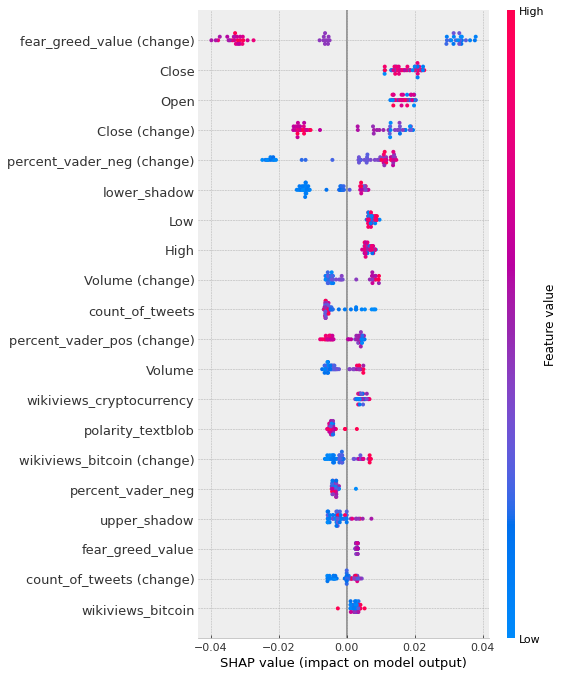

In [ ]:
shap.summary_plot(shap_values[1], X_test)

### AdaBoost

In [31]:
def objective(trial):
    classifier_obj =  AdaBoostClassifier(
          n_estimators=trial.suggest_int('n_estimators', 2, 200),
          learning_rate=trial.suggest_float('learning_rate', 0.01, 2.),
          algorithm=trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
          random_state=42
      )

    # score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    # accuracy = score.mean()
    # return accuracy
    clf=classifier_obj.fit(X_train, y_train)
    pred_test_labels=clf.predict(X_test)
    pred_val_labels=clf.predict(X_val)
    val_acc = accuracy_score(y_val, pred_val_labels)
    test_acc = accuracy_score(y_test, pred_test_labels)
    return min(val_acc,test_acc)

optimization_function = partial(objective)
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(optimization_function, n_trials=1000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-05 14:06:40,103] A new study created in memory with name: no-name-b39e481e-b37a-476a-9848-521fc61cc9e1
[I 2022-08-05 14:06:40,245] Trial 0 finished with value: 0.509090909090909 and parameters: {'n_estimators': 41, 'learning_rate': 1.7510774242866303, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.509090909090909.
[I 2022-08-05 14:06:40,828] Trial 1 finished with value: 0.6111111111111112 and parameters: {'n_estimators': 174, 'learning_rate': 0.8051654648270324, 'algorithm': 'SAMME.R'}. Best is trial 1 with value: 0.6111111111111112.
[I 2022-08-05 14:06:41,359] Trial 2 finished with value: 0.4727272727272727 and parameters: {'n_estimators': 171, 'learning_rate': 0.05725100048062245, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.6111111111111112.
[I 2022-08-05 14:06:42,019] Trial 3 finished with value: 0.45454545454545453 and parameters: {'n_estimators': 198, 'learning_rate': 1.4205283666787318, 'algorithm': 'SAMME.R'}. Best is trial 1 with value: 0.6111111111111

Number of finished trials:  1000
Best trial:
  Value: 0.6545454545454545
  Params: 
    n_estimators: 142
    learning_rate: 0.48708048614162014
    algorithm: SAMME.R


In [32]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value params_algorithm  params_learning_rate  params_n_estimators  \
484  0.654545          SAMME.R              0.457360                  145   
244  0.654545          SAMME.R              0.487080                  142   
679  0.654545          SAMME.R              0.536454                  193   

        state  
484  COMPLETE  
244  COMPLETE  
679  COMPLETE

Validation accuracy: 0.6666666666666666
Test accuracy: 0.6545454545454545
Classification report: 

              precision    recall  f1-score   support

           0       0.64      0.79      0.71        29
           1       0.68      0.50      0.58        26

    accuracy                           0.65        55
   macro avg       0.66      0.65      0.64        55
weighted avg       0.66      0.65      0.65        55

Log Loss: 11.93166452887062

Confusion Matrix: 

[[23  6]
 [13 13]]


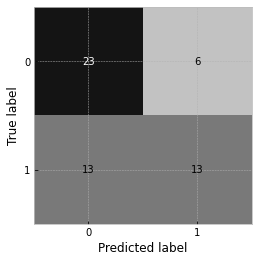

In [33]:
params = study.best_trial.params
clf = AdaBoostClassifier(**params, random_state=42)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False)
disp.im_.set_clim(0, 25)

plot test set

In [58]:
params = {'algorithm':'SAMME.R',
          'learning_rate': 0.457360,
          'n_estimators':145}

Validation accuracy: 0.6851851851851852
Test accuracy: 0.6545454545454545
Classification report: 

              precision    recall  f1-score   support

           0       0.64      0.79      0.71        29
           1       0.68      0.50      0.58        26

    accuracy                           0.65        55
   macro avg       0.66      0.65      0.64        55
weighted avg       0.66      0.65      0.65        55

Log Loss: 11.93166452887062

Confusion Matrix: 

[[23  6]
 [13 13]]


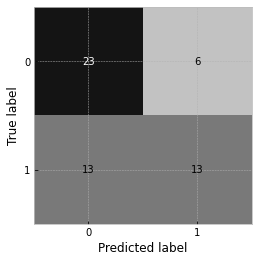

In [66]:
clf = AdaBoostClassifier(**params, random_state=42)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False)
disp.im_.set_clim(0, 25)

In [87]:
y_upward = close_test*y_predict

In [88]:
y_downward = close_test* (-(y_predict-1))

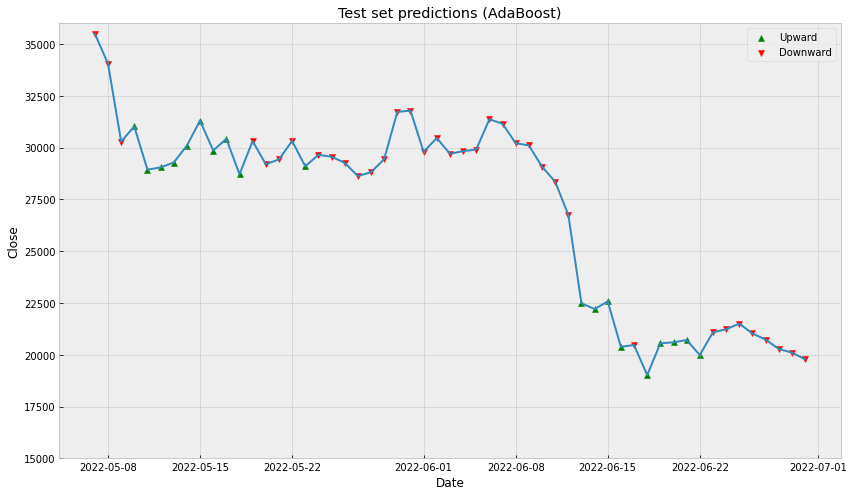

In [111]:
plt.figure(figsize=(14,8))
plt.title('Test set predictions (AdaBoost)')
plt.plot(X_test['Close'])
plt.scatter(y_upward.index,y_upward , label='Upward', marker='^', color='g')
plt.scatter(y_downward.index, y_downward, label='Downward', marker='v', color='r')
plt.ylim(15000,36000)
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

In [136]:
signals=np.where(y_predict>0,1,-1)

In [137]:
trades=pd.DataFrame({'signals':signals,
             'returns':close_test.pct_change()['Close'].shift(-1),
             'transaction fee': list((pd.Series(signals).pct_change()/200).fillna(0))
             })

In [142]:
trades['(1+r)-fee(%)'] = abs(trades['signals']+trades['returns'])+trades['transaction fee']

In [143]:
trades['cum_return'] = (trades['(1+r)-fee(%)'].cumprod()) - 1 

In [144]:
trades

signals   returns  transaction fee  (1+r)-fee(%)  cum_return
490       -1 -0.040637             0.00      1.040637    0.040637
491       -1 -0.110464             0.00      1.110464    0.155589
492       -1  0.023961             0.00      0.976039    0.127900
493        1 -0.067258            -0.01      0.922742    0.040760
494        1  0.003850             0.00      1.003850    0.044767
495        1  0.008102             0.00      1.008102    0.053232
496        1  0.027940             0.00      1.027940    0.082659
497        1  0.039993             0.00      1.039993    0.125958
498        1 -0.046069             0.00      0.953931    0.074086
499        1  0.018851             0.00      1.018851    0.094334
500        1 -0.056057             0.00      0.943943    0.032988
501        1  0.055503             0.00      1.055503    0.090322
502       -1 -0.036735            -0.01      1.026735    0.119472
503       -1  0.007927             0.00      0.992073    0.110598
504       -1  0.030290             0.00      0.969710    0.076958
505       -1 -0.040391             0.00      1.040391    0.120457
506        1  0.019130            -0.01      1.009130    0.130688
507       -1 -0.003144            -0.01      0.993144    0.122935
508       -1 -0.009984             0.00      1.009984    0.134146
509       -1 -0.021856             0.00      1.021856    0.158933
510       -1  0.006544             0.00      0.993456    0.151350
511       -1  0.021900             0.00      0.978100    0.126135
512       -1  0.077445             0.00      0.922555    0.038922
513       -1  0.002078             0.00      0.997922    0.036763
514       -1 -0.062695             0.00      1.062695    0.101763
515       -1  0.022430             0.00      0.977570    0.077050
516       -1 -0.025046             0.00      1.025046    0.104026
517       -1  0.004327             0.00      0.995673    0.099249
518       -1  0.002472             0.00      0.997528    0.096532
519       -1  0.048953             0.00      0.951047    0.042854
520       -1 -0.006860             0.00      1.006860    0.050008
521       -1 -0.030207             0.00      1.030207    0.081726
522       -1 -0.003388             0.00      1.003388    0.085390
523       -1 -0.034146             0.00      1.034146    0.122451
524       -1 -0.024859             0.00      1.024859    0.150354
525       -1 -0.056351             0.00      1.056351    0.215178
526       -1 -0.159747             0.00      1.159747    0.409300
527        1 -0.012478            -0.01      0.977522    0.377621
528        1  0.016484             0.00      1.016484    0.400330
529        1 -0.097072             0.00      0.902928    0.264397
530        1  0.004407             0.00      1.004407    0.269970
531       -1 -0.071018            -0.01      1.061018    0.347460
532        1  0.080748            -0.01      1.070748    0.442790
533        1  0.002251             0.00      1.002251    0.446038
534        1  0.005391             0.00      1.005391    0.453834
535        1 -0.034937             0.00      0.965063    0.403041
536        1  0.054978             0.00      1.054978    0.480178
537       -1  0.006914            -0.01      0.983086    0.455142
538       -1  0.012749             0.00      0.987251    0.436591
539       -1 -0.022093             0.00      1.022093    0.468329
540       -1 -0.013878             0.00      1.013878    0.488706
541       -1 -0.021936             0.00      1.021936    0.521362
542       -1 -0.008708             0.00      1.008708    0.534611
543       -1 -0.015882             0.00      1.015882    0.558984
544       -1       NaN             0.00           NaN         NaN

In [145]:
signals2 = np.ones(signals.shape)

In [151]:
(close_test.iloc[-1]-close_test.iloc[0])/close_test.iloc[0]

Close   -0.442714
dtype: float64

In [152]:
trades2=pd.DataFrame({'signals':signals2,
             'returns':close_test.pct_change()['Close'].shift(-1),
             'transaction fee': list((pd.Series(signals2).pct_change()/200).fillna(0))
             })

In [153]:
trades2['(1+r)-fee(%)'] = abs(trades2['signals']+trades2['returns'])+trades2['transaction fee']

In [154]:
trades2['cum_return'] = (trades2['(1+r)-fee(%)'].cumprod()) - 1 

In [155]:
trades2

signals   returns  transaction fee  (1+r)-fee(%)  cum_return
490      1.0 -0.040637              0.0      0.959363   -0.040637
491      1.0 -0.110464              0.0      0.889536   -0.146612
492      1.0  0.023961              0.0      1.023961   -0.126163
493      1.0 -0.067258              0.0      0.932742   -0.184936
494      1.0  0.003850              0.0      1.003850   -0.181798
495      1.0  0.008102              0.0      1.008102   -0.175169
496      1.0  0.027940              0.0      1.027940   -0.152124
497      1.0  0.039993              0.0      1.039993   -0.118214
498      1.0 -0.046069              0.0      0.953931   -0.158837
499      1.0  0.018851              0.0      1.018851   -0.142981
500      1.0 -0.056057              0.0      0.943943   -0.191023
501      1.0  0.055503              0.0      1.055503   -0.146122
502      1.0 -0.036735              0.0      0.963265   -0.177489
503      1.0  0.007927              0.0      1.007927   -0.170969
504      1.0  0.030290              0.0      1.030290   -0.145858
505      1.0 -0.040391              0.0      0.959609   -0.180357
506      1.0  0.019130              0.0      1.019130   -0.164677
507      1.0 -0.003144              0.0      0.996856   -0.167303
508      1.0 -0.009984              0.0      0.990016   -0.175616
509      1.0 -0.021856              0.0      0.978144   -0.193634
510      1.0  0.006544              0.0      1.006544   -0.188357
511      1.0  0.021900              0.0      1.021900   -0.170582
512      1.0  0.077445              0.0      1.077445   -0.106348
513      1.0  0.002078              0.0      1.002078   -0.104491
514      1.0 -0.062695              0.0      0.937305   -0.160635
515      1.0  0.022430              0.0      1.022430   -0.141808
516      1.0 -0.025046              0.0      0.974954   -0.163303
517      1.0  0.004327              0.0      1.004327   -0.159682
518      1.0  0.002472              0.0      1.002472   -0.157605
519      1.0  0.048953              0.0      1.048953   -0.116368
520      1.0 -0.006860              0.0      0.993140   -0.122429
521      1.0 -0.030207              0.0      0.969793   -0.148938
522      1.0 -0.003388              0.0      0.996612   -0.151821
523      1.0 -0.034146              0.0      0.965854   -0.180783
524      1.0 -0.024859              0.0      0.975141   -0.201148
525      1.0 -0.056351              0.0      0.943649   -0.246164
526      1.0 -0.159747              0.0      0.840253   -0.366587
527      1.0 -0.012478              0.0      0.987522   -0.374491
528      1.0  0.016484              0.0      1.016484   -0.364180
529      1.0 -0.097072              0.0      0.902928   -0.425901
530      1.0  0.004407              0.0      1.004407   -0.423370
531      1.0 -0.071018              0.0      0.928982   -0.464321
532      1.0  0.080748              0.0      1.080748   -0.421066
533      1.0  0.002251              0.0      1.002251   -0.419763
534      1.0  0.005391              0.0      1.005391   -0.416635
535      1.0 -0.034937              0.0      0.965063   -0.437016
536      1.0  0.054978              0.0      1.054978   -0.406064
537      1.0  0.006914              0.0      1.006914   -0.401958
538      1.0  0.012749              0.0      1.012749   -0.394334
539      1.0 -0.022093              0.0      0.977907   -0.407714
540      1.0 -0.013878              0.0      0.986122   -0.415934
541      1.0 -0.021936              0.0      0.978064   -0.428746
542      1.0 -0.008708              0.0      0.991292   -0.433721
543      1.0 -0.015882              0.0      0.984118   -0.442714
544      1.0       NaN              0.0           NaN         NaN

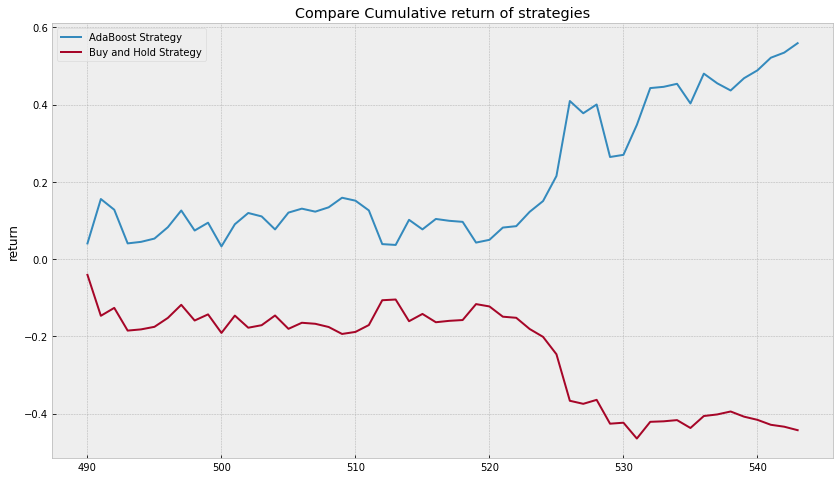

In [163]:
plt.figure(figsize=(14,8))
plt.title('Compare Cumulative return of strategies')
plt.plot(trades[['cum_return']], label='AdaBoost Strategy')
plt.plot(trades2[['cum_return']], label='Buy and Hold Strategy')
plt.ylabel('return')
plt.legend()

with lag

In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value params_algorithm  params_learning_rate  params_n_estimators  \
324  0.62963          SAMME.R              1.037006                  105   
205  0.62963          SAMME.R              1.027787                   98   
381  0.62963          SAMME.R              1.160560                   78   

        state  
324  COMPLETE  
205  COMPLETE  
381  COMPLETE

### XGBoost

In [34]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [35]:
def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    classifier_obj = xgb.XGBClassifier(**param, random_state=42)
    # score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    # accuracy = score.mean()

    # return accuracy
    clf=classifier_obj.fit(X_train, y_train)
    pred_test_labels=clf.predict(X_test)
    pred_val_labels=clf.predict(X_val)
    val_acc = accuracy_score(y_val, pred_val_labels)
    test_acc = accuracy_score(y_test, pred_test_labels)
    return min(val_acc,test_acc)

optimization_function = partial(objective)
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(optimization_function, n_trials=1000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-05 14:15:36,404] A new study created in memory with name: no-name-4fc638c5-16f2-476b-8a43-294305305fac
[I 2022-08-05 14:15:36,455] Trial 0 finished with value: 0.4727272727272727 and parameters: {'booster': 'gblinear', 'lambda': 0.003500945892980103, 'alpha': 5.3216694676618204e-08, 'subsample': 0.6084981459679526, 'colsample_bytree': 0.898178600340755}. Best is trial 0 with value: 0.4727272727272727.
[I 2022-08-05 14:15:36,608] Trial 1 finished with value: 0.4727272727272727 and parameters: {'booster': 'gbtree', 'lambda': 0.165012666059825, 'alpha': 9.46025932430635e-06, 'subsample': 0.8803394165122744, 'colsample_bytree': 0.9959471993874147, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.41773017788907635, 'gamma': 2.2175258014687915e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4727272727272727.
[I 2022-08-05 14:15:36,652] Trial 2 finished with value: 0.4727272727272727 and parameters: {'booster': 'gblinear', 'lambda': 2.7419350197973067e-05, 'alpha': 4

Number of finished trials:  1000
Best trial:
  Value: 0.5925925925925926
  Params: 
    booster: dart
    lambda: 3.1715055151866076e-08
    alpha: 5.984556366908227e-07
    subsample: 0.9653783225171255
    colsample_bytree: 0.42193458249167376
    max_depth: 5
    min_child_weight: 4
    eta: 3.2025851326096387e-06
    gamma: 0.2659062271097338
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: forest
    rate_drop: 4.152849222583581e-05
    skip_drop: 0.6098801296585061


In [36]:
gb_num = study.trials_dataframe().sort_values('value', ascending=False).groupby('params_booster').first().drop([ 'datetime_start', 'datetime_complete', 'duration'], axis=1).loc['gbtree', 'number']
params_gbtree = study.trials[gb_num].params

Validation accuracy: 0.5925925925925926
Test accuracy: 0.6
Classification report: 

              precision    recall  f1-score   support

           0       1.00      0.24      0.39        29
           1       0.54      1.00      0.70        26

    accuracy                           0.60        55
   macro avg       0.77      0.62      0.55        55
weighted avg       0.78      0.60      0.54        55

Log Loss: 13.815830396936358

Confusion Matrix: 

[[ 7 22]
 [ 0 26]]


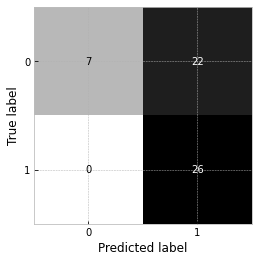

In [37]:
params = study.best_trial.params
clf = xgb.XGBClassifier(**params, random_state=42)
# clf = xgb.XGBClassifier(**params_gbtree, random_state=42)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False)
disp.im_.set_clim(0, 25)

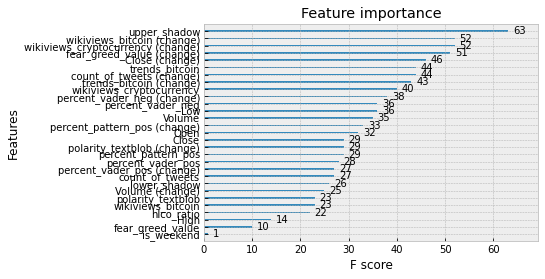

In [38]:
xgb.plot_importance(clf)

In [ ]:
# explainer = shap.Explainer(clf)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


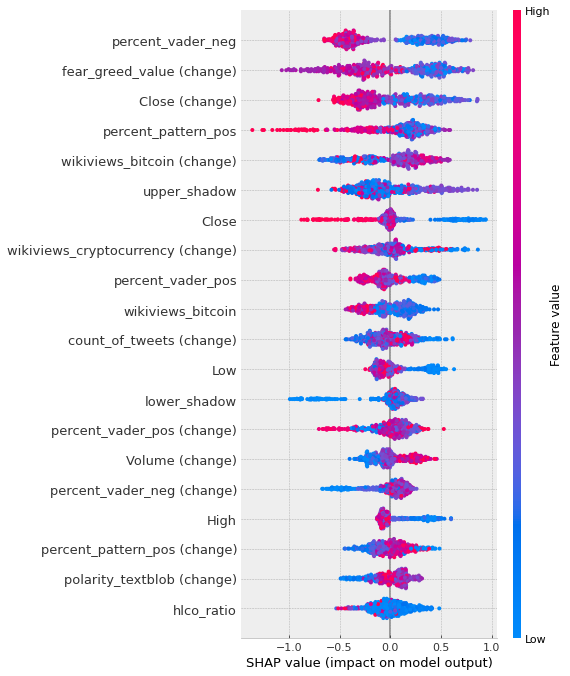

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
shap.plots.waterfall(shap_values[0])

with lag

Validation accuracy: 0.5740740740740741
Test accuracy: 0.5454545454545454
Classification report: 

              precision    recall  f1-score   support

           0       1.00      0.14      0.24        29
           1       0.51      1.00      0.68        26

    accuracy                           0.55        55
   macro avg       0.75      0.57      0.46        55
weighted avg       0.77      0.55      0.45        55

Log Loss: 15.699807269245861

Confusion Matrix: 

[[ 4 25]
 [ 0 26]]


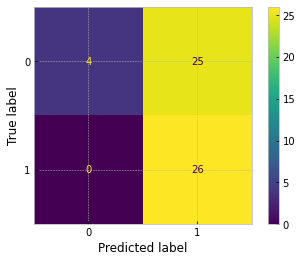

In [ ]:
params = study.best_trial.params
clf = xgb.XGBClassifier(**params, random_state=42)
# clf = xgb.XGBClassifier(**params_gbtree, random_state=42)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False) disp.im_.set_clim(0, 25)

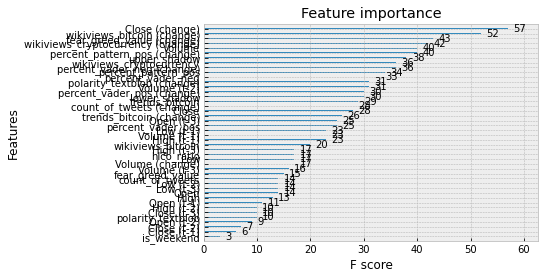

In [ ]:
xgb.plot_importance(clf)

In [ ]:
# explainer = shap.Explainer(clf)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

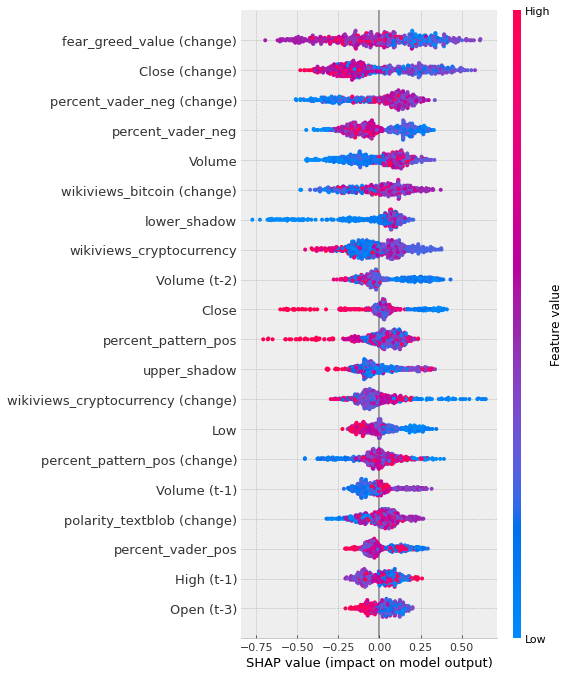

In [ ]:
shap.summary_plot(shap_values, X)

### LightGBM

In [39]:
import lightgbm as lgb

In [44]:
def objective(trial):
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0), #0.4, 1.0
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    classifier_obj = lgb.LGBMClassifier(**param, random_state=42)
    # score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    # accuracy = score.mean()
    # return accuracy
    clf=classifier_obj.fit(X_train, y_train)
    pred_test_labels=clf.predict(X_test)
    pred_val_labels=clf.predict(X_val)
    val_acc = accuracy_score(y_val, pred_val_labels)
    test_acc = accuracy_score(y_test, pred_test_labels)
    return min(val_acc,test_acc)

optimization_function = partial(objective)
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(optimization_function, n_trials=2000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-05 14:54:22,092] A new study created in memory with name: no-name-9979bfda-2d43-436a-9894-f01b47e373de
[I 2022-08-05 14:54:22,286] Trial 0 finished with value: 0.5185185185185185 and parameters: {'lambda_l1': 1.5492584805702995e-05, 'lambda_l2': 4.7108035208568095, 'num_leaves': 189, 'feature_fraction': 0.6752123543496291, 'bagging_fraction': 0.8068271626601738, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 0 with value: 0.5185185185185185.
[I 2022-08-05 14:54:22,370] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.0021603397882417217, 'lambda_l2': 0.0002226802984102559, 'num_leaves': 130, 'feature_fraction': 0.47797405000617105, 'bagging_fraction': 0.7855573878699024, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 0 with value: 0.5185185185185185.
[I 2022-08-05 14:54:22,494] Trial 2 finished with value: 0.46296296296296297 and parameters: {'lambda_l1': 0.7668942087531081, 'lambda_l2': 8.464104210270428, 'num_leaves': 251, 'feature_f

Number of finished trials:  2000
Best trial:
  Value: 0.5925925925925926
  Params: 
    lambda_l1: 0.0008642413725096134
    lambda_l2: 1.5394191675251963e-05
    num_leaves: 25
    feature_fraction: 0.6869071184475933
    bagging_fraction: 0.9574413111666279
    bagging_freq: 5
    min_child_samples: 19


In [46]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value  params_bagging_fraction  params_bagging_freq  \
1471  0.592593                 0.957441                    5   
1544  0.581818                 0.985662                    5   
1518  0.581818                 0.996944                    5   

      params_feature_fraction  params_lambda_l1  params_lambda_l2  \
1471                 0.686907      8.642414e-04      1.539419e-05   
1544                 0.728246      2.326954e-08      7.302570e-06   
1518                 0.679214      2.424986e-08      1.981839e-08   

      params_min_child_samples  params_num_leaves     state  
1471                        19                 25  COMPLETE  
1544                        22                 39  COMPLETE  
1518                        21                 32  COMPLETE

Validation accuracy: 0.5925925925925926
Test accuracy: 0.6
Classification report: 

              precision    recall  f1-score   support

           0       0.89      0.28      0.42        29
           1       0.54      0.96      0.69        26

    accuracy                           0.60        55
   macro avg       0.72      0.62      0.56        55
weighted avg       0.73      0.60      0.55        55

Log Loss: 13.815815858801264

Confusion Matrix: 

[[ 8 21]
 [ 1 25]]


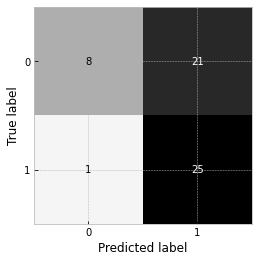

In [45]:
params = study.best_trial.params

clf = lgb.LGBMClassifier(**params,random_state=42, objective= "binary", metric="binary_logloss", verbosity=-1,boosting_type="gbdt")
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False) 
disp.im_.set_clim(0, 25)

In [47]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


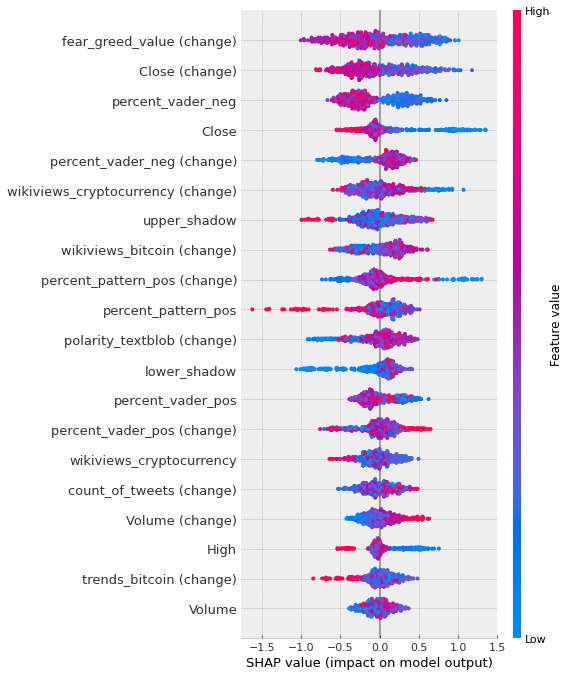

In [48]:
shap.summary_plot(shap_values[1], X)

with lag

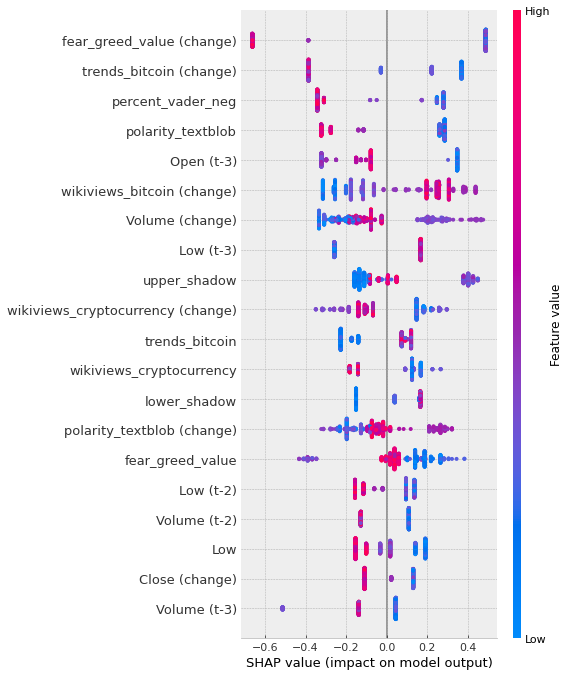

In [ ]:
shap.summary_plot(shap_values[1], X)

Validation accuracy: 0.6666666666666666
Test accuracy: 0.6363636363636364
Classification report: 

              precision    recall  f1-score   support

           0       0.70      0.55      0.62        29
           1       0.59      0.73      0.66        26

    accuracy                           0.64        55
   macro avg       0.64      0.64      0.64        55
weighted avg       0.65      0.64      0.63        55

Log Loss: 12.559744048451027

Confusion Matrix: 

[[16 13]
 [ 7 19]]


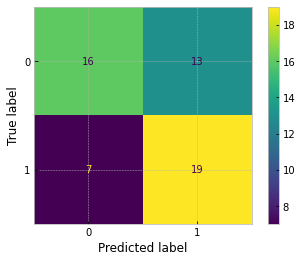

In [ ]:
params = study.best_trial.params

clf = lgb.LGBMClassifier(**params,random_state=42, objective= "binary", metric="binary_logloss", verbosity=-1,boosting_type="gbdt")
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False) disp.im_.set_clim(0, 25)

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### CatBoost

In [49]:
%%capture
!pip install catboost

In [50]:
from catboost import CatBoostClassifier, Pool

In [52]:
def objective(trial):

    param = {
        # 'max_depth': trial.suggest_int('max_depth', 3, 64),
        'n_estimators': trial.suggest_int('n_estimators', 500, 8000),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        # 'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 5e-3, 1e0), ### 1e-5
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        # "used_ram_limit": "3gb",
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20), ###
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    classifier_obj = CatBoostClassifier(**param, random_state=42)

    clf = classifier_obj.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

    # clf=classifier_obj.fit(X_train, y_train)
    pred_test_labels=clf.predict(X_test)
    pred_val_labels=clf.predict(X_val)
    val_acc = accuracy_score(y_val, pred_val_labels)
    test_acc = accuracy_score(y_test, pred_test_labels)
    return min(val_acc,test_acc)


optimization_function = partial(objective)
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(optimization_function, n_trials=1000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-05 15:09:11,005] A new study created in memory with name: no-name-c9b247ee-70ba-4833-a684-046dc46e7da5
[I 2022-08-05 15:09:12,957] Trial 0 finished with value: 0.46296296296296297 and parameters: {'n_estimators': 2320, 'max_bin': 257, 'min_data_in_leaf': 209, 'l2_leaf_reg': 0.01863440795018748, 'objective': 'CrossEntropy', 'learning_rate': 0.035284902546807516, 'colsample_bylevel': 0.06794407236122797, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.325740543456379}. Best is trial 0 with value: 0.46296296296296297.
[I 2022-08-05 15:09:13,064] Trial 1 finished with value: 0.4727272727272727 and parameters: {'n_estimators': 5969, 'max_bin': 347, 'min_data_in_leaf': 64, 'l2_leaf_reg': 0.0001853220373384477, 'objective': 'Logloss', 'learning_rate': 0.019912436366468236, 'colsample_bylevel': 0.05895242117729065, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.4727272727272727.
[I 2022-08

Number of finished trials:  1000
Best trial:
  Value: 0.6181818181818182
  Params: 
    n_estimators: 2460
    max_bin: 205
    min_data_in_leaf: 125
    l2_leaf_reg: 0.002081371262510277
    objective: CrossEntropy
    learning_rate: 0.01222269665966372
    colsample_bylevel: 0.08027882270005267
    depth: 14
    boosting_type: Plain
    bootstrap_type: MVS


In [53]:
study.trials_dataframe().sort_values('duration', ascending=False).drop(['number', 'datetime_start', 'datetime_complete'], axis=1).head(10)

value               duration  params_bagging_temperature  \
9    0.418182 0 days 00:09:04.460675                    3.680981   
416  0.444444 0 days 00:04:21.366511                    3.359794   
473  0.500000 0 days 00:03:54.786333                         NaN   
460  0.500000 0 days 00:03:51.609411                         NaN   
491  0.472727 0 days 00:03:21.643894                         NaN   
454  0.472727 0 days 00:02:38.079608                         NaN   
684  0.500000 0 days 00:02:08.063075                         NaN   
287  0.425926 0 days 00:02:05.826027                         NaN   
678  0.462963 0 days 00:02:01.662562                         NaN   
434  0.481481 0 days 00:01:56.952792                         NaN   

    params_boosting_type params_bootstrap_type  params_colsample_bylevel  \
9                Ordered              Bayesian                  0.097235   
416              Ordered              Bayesian                  0.082109   
473              Ordered             Bernoulli                  0.086047   
460              Ordered             Bernoulli                  0.086926   
491              Ordered             Bernoulli                  0.084049   
454              Ordered                   MVS                  0.080894   
684              Ordered             Bernoulli                  0.085590   
287              Ordered             Bernoulli                  0.080506   
678              Ordered             Bernoulli                  0.088008   
434              Ordered                   MVS                  0.076049   

     params_depth  params_l2_leaf_reg  params_learning_rate  params_max_bin  \
9              16            0.000183              0.492726             343   
416            16            0.001503              0.007868             395   
473            15            0.002583              0.013925             393   
460            15            0.002751              0.006842             380   
491            15            0.001403              0.006736             370   
454            16            0.338520              0.011970             291   
684            14            0.001968              0.009500             387   
287            15            0.509783              0.011822             310   
678            15            0.003038              0.007541             220   
434            16            0.001776              0.013918             231   

     params_min_data_in_leaf  params_n_estimators params_objective  \
9                        103                 4425          Logloss   
416                      139                 1825     CrossEntropy   
473                       91                 2194     CrossEntropy   
460                      253                 1996     CrossEntropy   
491                       97                 2271          Logloss   
454                      259                 2476     CrossEntropy   
684                      138                 2378     CrossEntropy   
287                      273                 1974     CrossEntropy   
678                      217                 1959          Logloss   
434                      109                 2250     CrossEntropy   

     params_subsample     state  
9                 NaN  COMPLETE  
416               NaN  COMPLETE  
473          0.738188  COMPLETE  
460          0.683233  COMPLETE  
491          0.176097  COMPLETE  
454               NaN  COMPLETE  
684          0.605606  COMPLETE  
287          0.166891  COMPLETE  
678          0.755859  COMPLETE  
434               NaN  COMPLETE

In [54]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value  params_bagging_temperature params_boosting_type  \
763  0.618182                         NaN                Plain   
774  0.618182                         NaN                Plain   
819  0.600000                         NaN                Plain   

    params_bootstrap_type  params_colsample_bylevel  params_depth  \
763                   MVS                  0.080279            14   
774                   MVS                  0.080154            14   
819                   MVS                  0.082042            15   

     params_l2_leaf_reg  params_learning_rate  params_max_bin  \
763            0.002081              0.012223             205   
774            0.002463              0.012649             205   
819            0.002424              0.007764             371   

     params_min_data_in_leaf  params_n_estimators params_objective  \
763                      125                 2460     CrossEntropy   
774                      100                 2615     CrossEntropy   
819                       84                 2565     CrossEntropy   

     params_subsample     state  
763               NaN  COMPLETE  
774               NaN  COMPLETE  
819               NaN  COMPLETE

In [ ]:
params

{'bagging_fraction': 0.9046958448681567,
 'bagging_freq': 1,
 'feature_fraction': 0.7604764483969494,
 'lambda_l1': 0.0024634214509159373,
 'lambda_l2': 1.2149519461829517e-05,
 'min_child_samples': 18,
 'num_leaves': 39}

Validation accuracy: 0.6296296296296297
Test accuracy: 0.6181818181818182
Classification report: 

              precision    recall  f1-score   support

           0       0.72      0.45      0.55        29
           1       0.57      0.81      0.67        26

    accuracy                           0.62        55
   macro avg       0.64      0.63      0.61        55
weighted avg       0.65      0.62      0.61        55

Log Loss: 13.187765415491048

Confusion Matrix: 

[[13 16]
 [ 5 21]]


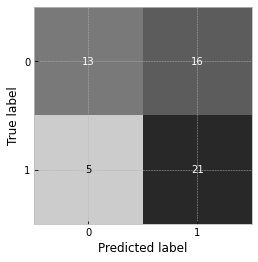

In [55]:
params = study.best_trial.params

clf = CatBoostClassifier(**params, random_state=42)
clf = clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False)
disp.im_.set_clim(0, 25)

In [56]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X)

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(Pool(X, y))

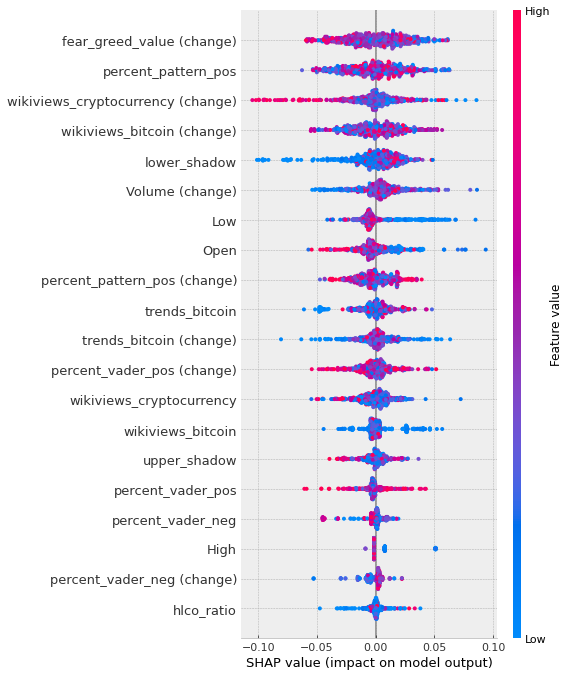

In [57]:
shap.summary_plot(shap_values, X)

In [ ]:
# shap.summary_plot(shap_values, X)

In [ ]:
# shap.summary_plot(shap_values[1], X)

with lag

Validation accuracy: 0.6111111111111112
Test accuracy: 0.6181818181818182
Classification report: 

              precision    recall  f1-score   support

           0       0.72      0.45      0.55        29
           1       0.57      0.81      0.67        26

    accuracy                           0.62        55
   macro avg       0.64      0.63      0.61        55
weighted avg       0.65      0.62      0.61        55

Log Loss: 13.187765415491047

Confusion Matrix: 

[[13 16]
 [ 5 21]]


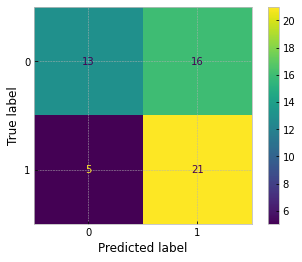

In [ ]:
params = study.best_trial.params

clf = CatBoostClassifier(**params, random_state=42)
clf = clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False) disp.im_.set_clim(0, 25)

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X)

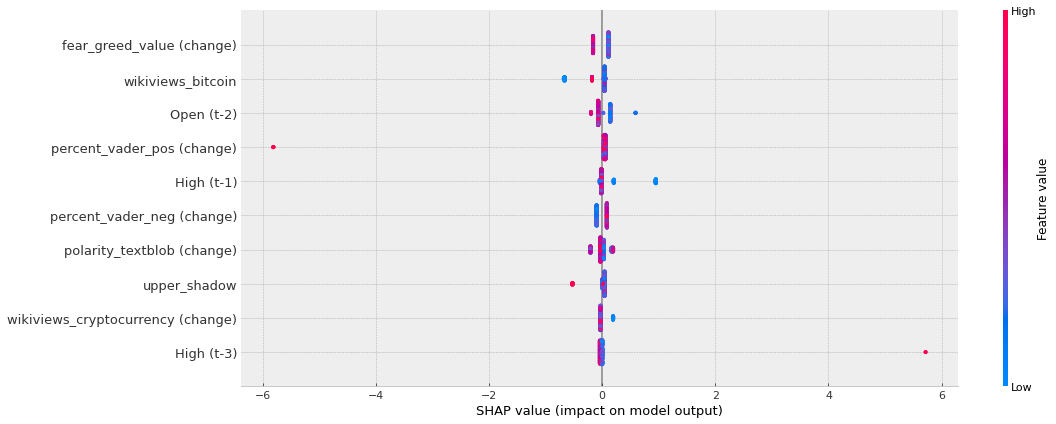

In [ ]:
# plt.xlim([-1, 1])
shap.summary_plot(shap_values, X,max_display=10, plot_size=(16,6))

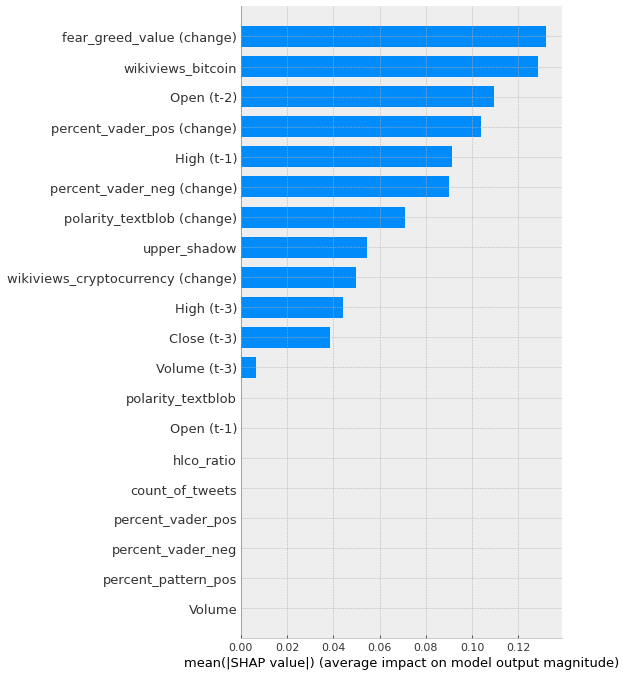

In [ ]:
shap.summary_plot(shap_values, X,plot_type='bar')

### Neural Network

In [64]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    layers = []
    for i in range(n_layers):
      layers.append(trial.suggest_int(f'n_units_{i}', 1, 256)) #128

    classifier_obj = MLPClassifier(
        solver=trial.suggest_categorical('solver',['sgd', 'adam']), 
        activation=trial.suggest_categorical('activation',['tanh', 'relu']),
        alpha=trial.suggest_float("alpha", 1e-4, 10, log=True),
        # hidden_layer_sizes=trial.suggest_categorical('hidden_layer_sizes',[(50,50,50), (50,100,50), (100,)]), 
        hidden_layer_sizes=tuple(layers),
        random_state=42,
        max_iter=1000,
        learning_rate_init=.1,
        learning_rate =trial.suggest_categorical('learning_rate',['constant','adaptive']),
        early_stopping=True,
        verbose=0
        )
    # score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    # accuracy = score.mean()
    # return accuracy
    clf=classifier_obj.fit(X_train.values, y_train.values)
    pred_test_labels=clf.predict(X_test.values)
    pred_val_labels=clf.predict(X_val.values)
    val_acc = accuracy_score(y_val.values, pred_val_labels)
    test_acc = accuracy_score(y_test.values, pred_test_labels)
    return min(val_acc,test_acc)

optimization_function = partial(objective)
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(optimization_function, n_trials=1000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-05 18:46:05,285] A new study created in memory with name: no-name-b84e019b-8a35-4db0-898a-13e359fc15c0
[I 2022-08-05 18:46:05,616] Trial 0 finished with value: 0.4727272727272727 and parameters: {'n_layers': 1, 'n_units_0': 246, 'solver': 'adam', 'activation': 'tanh', 'alpha': 0.09877996045792262, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.4727272727272727.
[I 2022-08-05 18:46:06,482] Trial 1 finished with value: 0.4727272727272727 and parameters: {'n_layers': 3, 'n_units_0': 254, 'n_units_1': 76, 'n_units_2': 139, 'solver': 'adam', 'activation': 'relu', 'alpha': 0.00045606573265548106, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.4727272727272727.
[I 2022-08-05 18:46:09,579] Trial 2 finished with value: 0.4444444444444444 and parameters: {'n_layers': 4, 'n_units_0': 201, 'n_units_1': 46, 'n_units_2': 82, 'n_units_3': 76, 'solver': 'sgd', 'activation': 'relu', 'alpha': 0.0035588953437870807, 'learning_rate': 'adaptive'}. Best is trial 0 with v

Number of finished trials:  1000
Best trial:
  Value: 0.5740740740740741
  Params: 
    n_layers: 3
    n_units_0: 44
    n_units_1: 1
    n_units_2: 123
    solver: sgd
    activation: relu
    alpha: 0.00011690035010091559
    learning_rate: adaptive


In [65]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value params_activation  params_alpha params_learning_rate  \
806  0.574074              relu      0.000125             adaptive   
676  0.574074              relu      0.000269             adaptive   
679  0.574074              relu      0.000289             adaptive   

     params_n_layers  params_n_units_0  params_n_units_1  params_n_units_2  \
806                1               182               NaN               NaN   
676                1               182               NaN               NaN   
679                1               182               NaN               NaN   

     params_n_units_3 params_solver     state  
806               NaN           sgd  COMPLETE  
676               NaN           sgd  COMPLETE  
679               NaN           sgd  COMPLETE

In [66]:
study.best_trial.params

{'activation': 'relu',
 'alpha': 0.00011690035010091559,
 'learning_rate': 'adaptive',
 'n_layers': 3,
 'n_units_0': 44,
 'n_units_1': 1,
 'n_units_2': 123,
 'solver': 'sgd'}

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

Validation accuracy: 0.5740740740740741
Test accuracy: 0.5818181818181818
Classification report: 

              precision    recall  f1-score   support

           0       0.59      0.69      0.63        29
           1       0.57      0.46      0.51        26

    accuracy                           0.58        55
   macro avg       0.58      0.58      0.57        55
weighted avg       0.58      0.58      0.58        55

Log Loss: 14.443619153814865

Confusion Matrix: 

[[20  9]
 [14 12]]


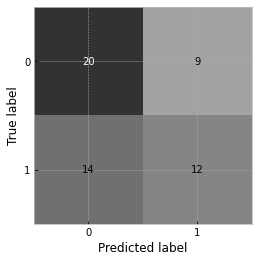

In [67]:
params = study.best_trial.params
clf = MLPClassifier(activation = params['activation'],
                    alpha=params['alpha'],
                    learning_rate = params['learning_rate'],
                    hidden_layer_sizes=(44,1,123),
                    solver = params['solver'],
                    random_state=42,
                    max_iter=1000,
                    learning_rate_init=.1,
                    early_stopping=True
                    )



clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False)
disp.im_.set_clim(0, 25)

### Naive Bayes

In [ ]:
def objective(trial):
    classifier_obj = GaussianNB(
          var_smoothing=trial.suggest_float("var_smoothing", 1e-9, 1, log=True)
          )
    # score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    # accuracy = score.mean()
    # return accuracy
    clf=classifier_obj.fit(X_train, y_train)
    pred_test_labels=clf.predict(X_test)
    pred_val_labels=clf.predict(X_val)
    val_acc = accuracy_score(y_val, pred_val_labels)
    test_acc = accuracy_score(y_test, pred_test_labels)
    return min(val_acc,test_acc)

optimization_function = partial(objective)
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(optimization_function, n_trials=500)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-27 16:29:25,943] A new study created in memory with name: no-name-625bd2e6-1e0c-4ef6-a30e-8534eb997974
[I 2022-07-27 16:29:25,960] Trial 0 finished with value: 0.48148148148148145 and parameters: {'var_smoothing': 4.893291345434329e-07}. Best is trial 0 with value: 0.48148148148148145.
[I 2022-07-27 16:29:25,978] Trial 1 finished with value: 0.48148148148148145 and parameters: {'var_smoothing': 4.9914377043391475e-09}. Best is trial 0 with value: 0.48148148148148145.
[I 2022-07-27 16:29:25,996] Trial 2 finished with value: 0.48148148148148145 and parameters: {'var_smoothing': 4.022243880191023e-06}. Best is trial 0 with value: 0.48148148148148145.
[I 2022-07-27 16:29:26,013] Trial 3 finished with value: 0.4909090909090909 and parameters: {'var_smoothing': 8.76869229562366e-05}. Best is trial 3 with value: 0.4909090909090909.
[I 2022-07-27 16:29:26,028] Trial 4 finished with value: 0.4909090909090909 and parameters: {'var_smoothing': 0.00017550518212125317}. Best is trial 3 w

Number of finished trials:  500
Best trial:
  Value: 0.4909090909090909
  Params: 
    var_smoothing: 8.76869229562366e-05


In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value  params_var_smoothing     state
250  0.490909              0.000638  COMPLETE
307  0.490909              0.000343  COMPLETE
337  0.490909              0.002713  COMPLETE

Validation accuracy: 0.5
Test accuracy: 0.4909090909090909
Classification report: 

              precision    recall  f1-score   support

           0       1.00      0.03      0.07        29
           1       0.48      1.00      0.65        26

    accuracy                           0.49        55
   macro avg       0.74      0.52      0.36        55
weighted avg       0.75      0.49      0.34        55

Log Loss: 17.583784141555363

Confusion Matrix: 

[[ 1 28]
 [ 0 26]]


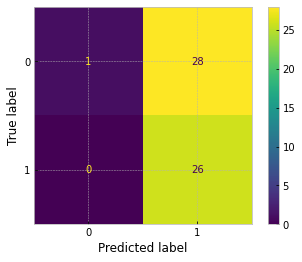

In [ ]:
params = study.best_trial.params
clf = GaussianNB(**params)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False) disp.im_.set_clim(0, 25)

### Logistic Regression

In [ ]:
def objective(trial):
    # penalty=trial.suggest_categorical('penalty', ['l2', 'l1']),
      # if penalty == 'l1':
      #   solver = 'saga'
      # else:
      #   solver = 'lbfgs' 
    classifier_obj = LogisticRegression(
          tol=trial.suggest_uniform('tol' , 1e-6 , 1e-3),
          # penalty=penalty,
          C=trial.suggest_uniform('C', 0.01, 10), 
          # solver=solver,
      )
    # score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
    # accuracy = score.mean()
    # return accuracy
    clf=classifier_obj.fit(X_train, y_train)
    pred_test_labels=clf.predict(X_test)
    pred_val_labels=clf.predict(X_val)
    val_acc = accuracy_score(y_val, pred_val_labels)
    test_acc = accuracy_score(y_test, pred_test_labels)
    return min(val_acc,test_acc)

optimization_function = partial(objective)
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(optimization_function, n_trials=500)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-27 16:54:45,941] A new study created in memory with name: no-name-0f941f32-9066-4f68-b143-14b2affa3e49
[I 2022-07-27 16:54:46,014] Trial 0 finished with value: 0.4727272727272727 and parameters: {'tol': 0.00021941450513197046, 'C': 3.2970238474533673}. Best is trial 0 with value: 0.4727272727272727.
[I 2022-07-27 16:54:46,099] Trial 1 finished with value: 0.5 and parameters: {'tol': 0.0006393193916479831, 'C': 5.374926064656007}. Best is trial 1 with value: 0.5.
[I 2022-07-27 16:54:46,163] Trial 2 finished with value: 0.4727272727272727 and parameters: {'tol': 0.0005561946474478112, 'C': 3.9989159015173765}. Best is trial 1 with value: 0.5.
[I 2022-07-27 16:54:46,204] Trial 3 finished with value: 0.4727272727272727 and parameters: {'tol': 0.0004499028118337985, 'C': 0.48532407412953943}. Best is trial 1 with value: 0.5.
[I 2022-07-27 16:54:46,259] Trial 4 finished with value: 0.4727272727272727 and parameters: {'tol': 0.0005729494010903654, 'C': 1.4495779805922437}. Best is 

Number of finished trials:  500
Best trial:
  Value: 0.5
  Params: 
    tol: 0.0006393193916479831
    C: 5.374926064656007


In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).drop(['number', 'datetime_start', 'datetime_complete', 'duration'], axis=1).head(3)

value  params_C  params_tol     state
150    0.5  5.956877    0.000071  COMPLETE
198    0.5  6.039430    0.000265  COMPLETE
180    0.5  5.876975    0.000348  COMPLETE

Validation accuracy: 0.5
Test accuracy: 0.509090909090909
Classification report: 

              precision    recall  f1-score   support

           0       0.75      0.10      0.18        29
           1       0.49      0.96      0.65        26

    accuracy                           0.51        55
   macro avg       0.62      0.53      0.42        55
weighted avg       0.63      0.51      0.40        55

Log Loss: 16.955777312650433

Confusion Matrix: 

[[ 3 26]
 [ 1 25]]


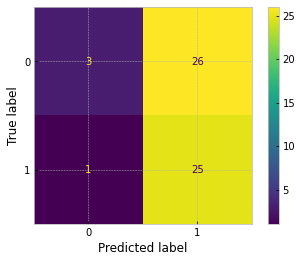

In [ ]:
params = study.best_trial.params
clf = LogisticRegression(**params)
clf = clf.fit(X_train, y_train)

print('Validation accuracy:', accuracy_score(y_val, clf.predict(X_val))) 
print('Test accuracy:', accuracy_score(y_test, clf.predict(X_test)))

y_predict = clf.predict(X_test)
print('Classification report: \n')
print(classification_report(y_test, y_predict))
print(f'Log Loss: {log_loss(y_test, y_predict)}\n')
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict))
disp=ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary', colorbar=False) disp.im_.set_clim(0, 25)

---

### All models

In [ ]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", 
                                                [
                                                         "Nearest Neighbors",
                                                         "Linear SVM",
                                                         "RBF SVM",
                                                        #  "Gaussian Process",
                                                         "Decision Tree",
                                                 "Logistic Regression",
                                                         "Random Forest",
                                                         "Neural Net",
                                                         "AdaBoost",
                                                         "Naive Bayes",
                                                         "QDA"
                                                 ]
                                                )
    if classifier_name == "Nearest Neighbors":
      classifier_obj = KNeighborsClassifier(
          leaf_size = trial.suggest_int('leaf_size', 1, 50),
          n_neighbors = trial.suggest_int('n_neighbors', 1,30),
          p=trial.suggest_int('p', 1,2),
          weights=trial.suggest_categorical('weights',['uniform', 'distance']),
          metric = trial.suggest_categorical('metric',['minkowski', 'chebyshev']),
      )
    elif classifier_name == "Linear SVM":
      classifier_obj = SVC(kernel="linear",
                           C=trial.suggest_float("svc_c", 1e-5, 1e3, log=True))
      
    elif classifier_name == "RBF SVM":
      classifier_obj = SVC(gamma=2, C=1)

    # elif classifier_name == "Gaussian Process":
    #   classifier_obj = GaussianProcessClassifier(
    #       # kernel = 1.0 * RBF(1.0)
    #       kernel = trial.suggest_categorical("Guassian Kernel", [
    #                                                               1.0 * RationalQuadratic(alpha=1, length_scale=1), 
    #                                                              1.0 * RBF(length_scale=1),
    #                                                              1.0 * DotProduct(sigma_0=1),
    #                                                              1.0 * Matern(length_scale=1, nu=1.5),
    #                                                              1.0 * RationalQuadratic(alpha=1, length_scale=1),
    #                                                              1.0 * WhiteKernel(noise_level=1),
    #       ]
    #       ))
      
    elif classifier_name == "Decision Tree":
      classifier_obj = DecisionTreeClassifier(
          max_depth=trial.suggest_int('max_depth', 5, 20), 
          min_samples_split=trial.suggest_int('min_samples_split', 2, 20), 
          min_samples_leaf=trial.suggest_int('min_samples_leaf', 2, 20)
          )
    elif classifier_name == "Random Forest":
      classifier_obj = RandomForestClassifier(
            n_estimators=trial.suggest_int("rf_n_estimators", 10, 200),
            max_depth=trial.suggest_int("rf_max_depth", 2, 32, log=True),
            max_features = trial.suggest_uniform("rf_max_features", 0.01, 1.0), 
            criterion = trial.suggest_categorical("rf_criterion", ["gini", "entropy"])
        )
    elif classifier_name == "Logistic Regression":
      # penalty=trial.suggest_categorical('penalty', ['l2', 'l1']),
      # if penalty == 'l1':
      #   solver = 'saga'
      # else:
      #   solver = 'lbfgs' 
      classifier_obj = LogisticRegression(
          tol=trial.suggest_uniform('log_tol' , 1e-6 , 1e-3),
          # penalty=penalty,
          C=trial.suggest_uniform('logistic-regularization', 0.01, 10), 
          # solver=solver,
      )

    elif classifier_name == "Neural Net":

      n_layers = trial.suggest_int('n_layers', 1, 4)
      layers = []
      for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))

      classifier_obj = MLPClassifier(
          solver=trial.suggest_categorical('solver',['sgd', 'adam']), 
          activation=trial.suggest_categorical('activation',['tanh', 'relu']),
          alpha=trial.suggest_float("alpha", 1e-4, 0.1, log=True),
          # hidden_layer_sizes=trial.suggest_categorical('hidden_layer_sizes',[(50,50,50), (50,100,50), (100,)]), 
          hidden_layer_sizes=tuple(layers),
          random_state=1,
          max_iter=200,
          learning_rate_init=.1,
          learning_rate =trial.suggest_categorical('learning_rate_mlp',['constant','adaptive']),
          )
    elif classifier_name == "AdaBoost":
      classifier_obj = AdaBoostClassifier(
          n_estimators=trial.suggest_categorical('n_estimators', [10, 20, 50, 100, 200]),
          learning_rate=trial.suggest_float('learning_rate_adaboost', 0.1, 2.),
          algorithm=trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),

      )
    elif classifier_name == "Naive Bayes":
      classifier_obj = GaussianNB(
          var_smoothing=trial.suggest_float("var_smoothing", 1e-9, 1, log=True)
          )
    elif classifier_name == "QDA":
      classifier_obj = QuadraticDiscriminantAnalysis(
          reg_param=trial.suggest_categorical('reg_param',[0.00001, 0.0001, 0.001,0.01, 0.1]), 
          store_covariance=trial.suggest_categorical('store_covariance', [True, False]),
          tol=trial.suggest_categorical('qda_tol', [0.0001, 0.001, 0.01, 0.1])
      )

    # preds = classifier_obj.fit(X_train, y_train).predict(X_test)
    # pred_labels = np.rint(preds)
    # accuracy = accuracy_score(y_test, pred_labels)

    score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    
    # print(classifier_name)
    # val_accuracy = clf.score(X_test, y_test)
    return accuracy

In [ ]:
optimization_function = partial(objective)

In [ ]:
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(optimization_function, n_trials=1000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-25 13:43:36,256] A new study created in memory with name: no-name-96640d4a-c1f2-4289-92b4-33adea9ca717
[I 2022-07-25 13:43:39,191] Trial 0 finished with value: 0.5064861473701252 and parameters: {'classifier': 'QDA', 'reg_param': 1e-05, 'store_covariance': True, 'qda_tol': 0.0001}. Best is trial 0 with value: 0.5064861473701252.
[I 2022-07-25 13:43:39,298] Trial 1 finished with value: 0.5046040515653775 and parameters: {'classifier': 'Linear SVM', 'svc_c': 0.0001387607818614768}. Best is trial 0 with value: 0.5064861473701252.
[I 2022-07-25 13:43:39,379] Trial 2 finished with value: 0.4899823932973104 and parameters: {'classifier': 'Naive Bayes', 'var_smoothing': 0.2573971382082988}. Best is trial 0 with value: 0.5064861473701252.
[I 2022-07-25 13:43:39,504] Trial 3 finished with value: 0.48439681865096235 and parameters: {'classifier': 'Logistic Regression', 'log_tol': 2.7239475093125093e-05, 'logistic-regularization': 5.8594427892012035}. Best is trial 0 with value: 0.5064

Number of finished trials:  1000
Best trial:
  Value: 0.55043207253152
  Params: 
    classifier: AdaBoost
    n_estimators: 100
    learning_rate_adaboost: 1.0503699740443797
    algorithm: SAMME.R


In [ ]:
print(study.best_trial)

FrozenTrial(number=88, values=[0.5494505494505494], datetime_start=datetime.datetime(2022, 7, 24, 21, 53, 13, 738370), datetime_complete=datetime.datetime(2022, 7, 24, 21, 53, 13, 833333), params={'classifier': 'Decision Tree', 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 12}, distributions={'classifier': CategoricalDistribution(choices=('Nearest Neighbors', 'Linear SVM', 'RBF SVM', 'Decision Tree', 'Logistic Regression', 'Random Forest', 'Neural Net', 'AdaBoost', 'Naive Bayes', 'QDA')), 'max_depth': IntUniformDistribution(high=20, low=5, step=1), 'min_samples_split': IntUniformDistribution(high=20, low=2, step=1), 'min_samples_leaf': IntUniformDistribution(high=20, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=88, state=TrialState.COMPLETE, value=None)


In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).groupby('params_classifier').first().sort_values('value', ascending=False)

number     value             datetime_start  \
params_classifier                                                  
AdaBoost                684  0.550432 2022-07-25 13:51:02.035842   
Decision Tree           848  0.528444 2022-07-25 13:53:19.022569   
Random Forest             7  0.522970 2022-07-25 13:43:39.887864   
Nearest Neighbors        33  0.519307 2022-07-25 13:43:55.839905   
Linear SVM              125  0.508267 2022-07-25 13:44:50.738550   
QDA                     146  0.506486 2022-07-25 13:45:02.243267   
Neural Net              578  0.502712 2022-07-25 13:49:38.629819   
Logistic Regression     899  0.493575 2022-07-25 13:53:56.044443   
Naive Bayes              46  0.491814 2022-07-25 13:44:02.576385   
RBF SVM                 268  0.480784 2022-07-25 13:46:18.350173   

                             datetime_complete               duration  \
params_classifier                                                       
AdaBoost            2022-07-25 13:51:02.748187 0 days 00:00:00.712345   
Decision Tree       2022-07-25 13:53:19.092993 0 days 00:00:00.070424   
Random Forest       2022-07-25 13:43:42.166872 0 days 00:00:02.279008   
Nearest Neighbors   2022-07-25 13:43:55.938707 0 days 00:00:00.098802   
Linear SVM          2022-07-25 13:44:50.794839 0 days 00:00:00.056289   
QDA                 2022-07-25 13:45:02.283144 0 days 00:00:00.039877   
Neural Net          2022-07-25 13:49:40.361038 0 days 00:00:01.731219   
Logistic Regression 2022-07-25 13:53:56.141225 0 days 00:00:00.096782   
Naive Bayes         2022-07-25 13:44:02.648262 0 days 00:00:00.071877   
RBF SVM             2022-07-25 13:46:18.424317 0 days 00:00:00.074144   

                    params_activation params_algorithm  params_alpha  \
params_classifier                                                      
AdaBoost                         None          SAMME.R           NaN   
Decision Tree                    None             None           NaN   
Random Forest                    None             None           NaN   
Nearest Neighbors                None             None           NaN   
Linear SVM                       None             None           NaN   
QDA                              None             None           NaN   
Neural Net                       tanh             None      0.001413   
Logistic Regression              None             None           NaN   
Naive Bayes                      None             None           NaN   
RBF SVM                          None             None           NaN   

                     params_leaf_size  params_learning_rate_adaboost  ...  \
params_classifier                                                     ...   
AdaBoost                          NaN                        1.05037  ...   
Decision Tree                     NaN                            NaN  ...   
Random Forest                     NaN                            NaN  ...   
Nearest Neighbors                31.0                            NaN  ...   
Linear SVM                        NaN                            NaN  ...   
QDA                               NaN                            NaN  ...   
Neural Net                        NaN                            NaN  ...   
Logistic Regression               NaN                            NaN  ...   
Naive Bayes                       NaN                            NaN  ...   
RBF SVM                           NaN                            NaN  ...   

                    params_rf_criterion  params_rf_max_depth  \
params_classifier                                              
AdaBoost                           None                  NaN   
Decision Tree                      None                  NaN   
Random Forest                      gini                 11.0   
Nearest Neighbors                  None                  NaN   
Linear SVM                         None                  NaN   
QDA                                None                  NaN   
Neural Net               

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def objective(trial):
    # (data, target) = sklearn.datasets.load_breast_cancer(return_X_y=True)
    # train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)

    # score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=3)
    # accuracy = score.mean()
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-25 15:03:02,395] A new study created in memory with name: no-name-ac92601e-c263-420c-a197-8a272c423182
[I 2022-07-25 15:03:02,501] Trial 0 finished with value: 0.45454545454545453 and parameters: {'booster': 'dart', 'lambda': 0.012594243376992397, 'alpha': 4.3047567260003396e-07, 'subsample': 0.8889974232925735, 'colsample_bytree': 0.5765923513483165, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.00123032717920044, 'gamma': 0.010303316880104222, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.64055172220395e-05, 'skip_drop': 0.000395211104280654}. Best is trial 0 with value: 0.45454545454545453.
[I 2022-07-25 15:03:02,581] Trial 1 finished with value: 0.43636363636363634 and parameters: {'booster': 'gbtree', 'lambda': 0.0002781391426422994, 'alpha': 0.00011295034108703583, 'subsample': 0.4787266496604232, 'colsample_bytree': 0.21440799772519298, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.06600825603808587, 'gamma': 9.180

Number of finished trials:  500
Best trial:
  Value: 0.6363636363636364
  Params: 
    booster: dart
    lambda: 0.043963301919644406
    alpha: 0.0036710758538349483
    subsample: 0.9546629077696689
    colsample_bytree: 0.6577966556346677
    max_depth: 5
    min_child_weight: 4
    eta: 5.476884569761423e-08
    gamma: 0.04579008961852317
    grow_policy: lossguide
    sample_type: uniform
    normalize_type: tree
    rate_drop: 2.292868045423025e-08
    skip_drop: 2.163887889825094e-08


In [ ]:
study.trials_dataframe().sort_values('value', ascending=False)

NameError: ignored

### LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def objective(trial):

    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-24 21:56:58,349] A new study created in memory with name: no-name-73b9641a-9f10-4bb4-a68c-dbf4e3a15de6
[I 2022-07-24 21:56:58,401] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 0.0005495118321808582, 'lambda_l2': 0.0007213474516671219, 'num_leaves': 174, 'feature_fraction': 0.5443002178369662, 'bagging_fraction': 0.7778205316853446, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 0 with value: 0.5.
[I 2022-07-24 21:56:58,432] Trial 1 finished with value: 0.5454545454545454 and parameters: {'lambda_l1': 5.515283847645896e-08, 'lambda_l2': 0.25942076130513375, 'num_leaves': 125, 'feature_fraction': 0.43509426009800534, 'bagging_fraction': 0.8533796826604614, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 1 with value: 0.5454545454545454.
[I 2022-07-24 21:56:58,455] Trial 2 finished with value: 0.4818181818181818 and parameters: {'lambda_l1': 3.331974692681721e-05, 'lambda_l2': 9.115606227925697e-07, 'num_leaves': 34, 'feature_fraction': 

Number of finished trials: 1000
Best trial:
  Value: 0.6454545454545455
  Params: 
    lambda_l1: 0.00020811272849697676
    lambda_l2: 0.011326357808212966
    num_leaves: 203
    feature_fraction: 0.7775552007432684
    bagging_fraction: 0.4658922877339469
    bagging_freq: 6
    min_child_samples: 99


### CatBoost

In [ ]:
%%capture
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool, cv

In [ ]:
cv_dataset = Pool(data=X,
                  label=y,
                  # cat_features=[0]
                  )

params = {"iterations": 100,
          "depth": 2,
          "loss_function": "Logloss",
          "custom_metric": "Accuracy",
          "verbose": True,
          # "roc_file": "roc-file"
          }

In [ ]:
def objective(trial):
    # train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0), ### 
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20), ###
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2022-07-24 21:59:20,656] A new study created in memory with name: no-name-457804cb-73f9-4cc4-ae54-9c790a733512
[I 2022-07-24 21:59:20,901] Trial 0 finished with value: 0.4909090909090909 and parameters: {'objective': 'CrossEntropy', 'learning_rate': 0.6325346572879657, 'colsample_bylevel': 0.03507935481856344, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 7, 'bagging_temperature': 9.754542837189833}. Best is trial 0 with value: 0.4909090909090909.
[I 2022-07-24 21:59:22,399] Trial 1 finished with value: 0.509090909090909 and parameters: {'objective': 'CrossEntropy', 'learning_rate': 0.007301287641005593, 'colsample_bylevel': 0.0720500188338697, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'subsample': 0.4922228378904845}. Best is trial 1 with value: 0.509090909090909.
[I 2022-07-24 21:59:25,370] Trial 2 finished with value: 0.5181818181818182 and parameters: {'objective': 'Logloss', 'learnin

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.5342465753424658
  Params: 
    objective: CrossEntropy
    learning_rate: 1.3767008717866315e-05
    colsample_bylevel: 0.027877368687495463
    depth: 5
    boosting_type: Plain
    bootstrap_type: Bayesian
    min_data_in_leaf: 15
    bagging_temperature: 2.7938835731871023


# Explain

In [ ]:
%%capture
!pip install shap

In [ ]:
import shap

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
import graphviz

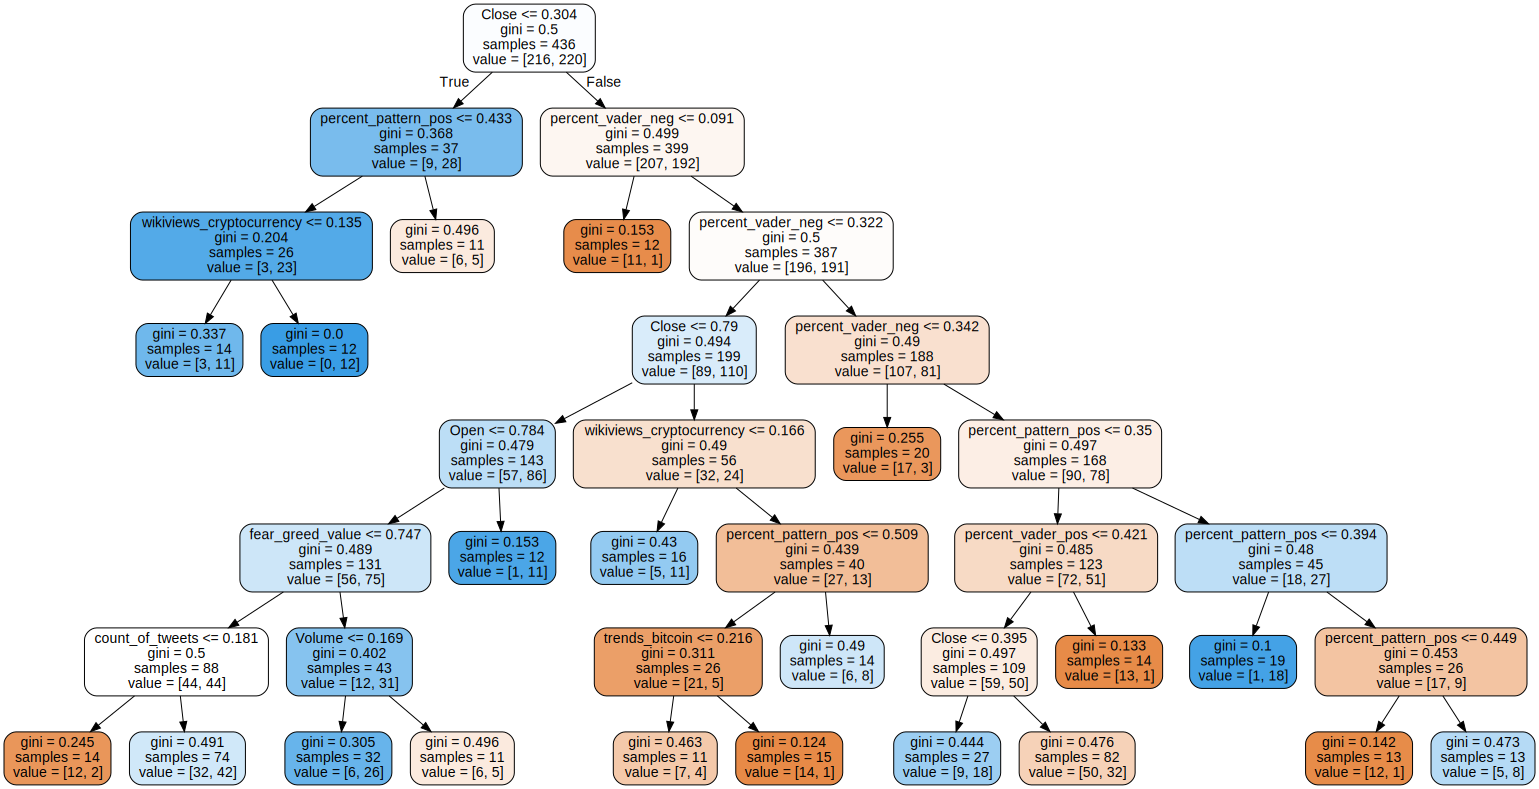

In [ ]:
 # train the model data
 classifier_obj.fit(X_train, y_train)
 # Visualize how model classified the entire data
 tree_graph = export_graphviz(classifier_obj, out_file=None, 
                              feature_names = daily_data.drop(['next_close_label','next_open_label'], axis=1).columns, 
                              rounded=True, filled=True)
 graphviz.Source(tree_graph) 

In [ ]:
X_test = pd.DataFrame(X_test, columns = daily_data.drop(['next_close_label','next_open_label'], axis=1).columns)

In [ ]:
 shap.initjs()
 # Define a tree explainer for the built model
 explainer = shap.TreeExplainer(classifier_obj)
 # obtain shap values for the first row of the test data
 shap_values = explainer.shap_values(X_test.iloc[0])
 shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])

In [ ]:
 shap.initjs() 
 # obtain shap values for the test data
 shap_values = explainer.shap_values(X_test)
 shap.force_plot(explainer.expected_value[0], shap_values[0], X_test) 

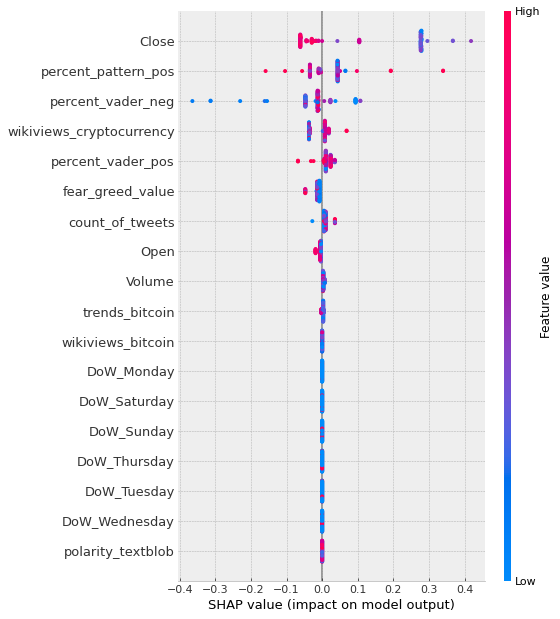

In [ ]:
shap.summary_plot(shap_values[1], X_test)

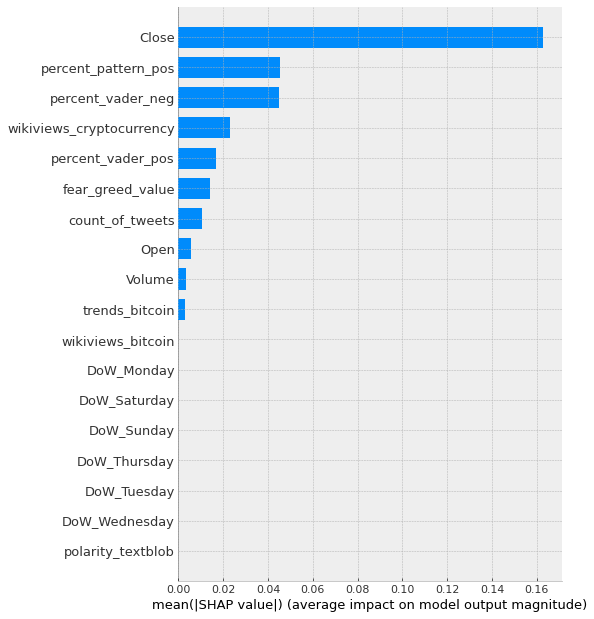

In [ ]:
shap.summary_plot(shap_values[1], X_test, plot_type='bar')